# Boston Houses' prices prediction

In [272]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd

## Load in the data

In [273]:
!wget https://lazyprogrammer.me/course_files/exercises/boston.txt

--2025-04-06 10:44:46--  https://lazyprogrammer.me/course_files/exercises/boston.txt
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: 'boston.txt.1'

     0K .......... .......... .......... .......... ..........  637K
    50K                                                        1,04G=0,08s

2025-04-06 10:44:47 (638 KB/s) - 'boston.txt.1' saved [51256]



### Process the text file

In [274]:
def create_csv_file(in_file, out_file):
    with open(out_file, 'w') as out_f:
        with open(in_file, 'r') as in_f:
            i = 22  # Number of line to skips
            count = 0
            for line in in_f:
                if i == 0:
                    data = line.strip().split(" ")
                    if len(data) == 0: continue
                    # Write to output file
                    for num in data:
                        # Skip non-numeric fields (due to split by just a whitespace)
                        if len(num) == 0: continue
                        out_f.write(num.strip())
                        count += 1
                        if count != 14:
                            out_f.write(',')
                        # Finished reading a row, move to next line
                        else:
                            count = 0
                            out_f.write('\n')
                
                # Skip line 
                else: i -= 1

In [275]:
# Create a csv file with the data only
create_csv_file("boston.txt", "boston.csv")

### Read csv file into a numpy array

In [414]:
data = pd.read_csv("boston.csv", header=None).to_numpy(dtype=np.float32)

# Shuffle the data
np.random.shuffle(data)

In [415]:
X = data[:, :12]  # The first 12 fields are features
inputs = X.copy()
y = data[:, 13].reshape(-1, 1)  # the last field is the price
outputs = y.copy()

In [416]:
# Verify shape
X.shape, y.shape

((506, 12), (506, 1))

#### Processing the data

1. Standardize
2. Convert into torch Tensor 
3. Split into test set and training set

In [417]:
# Standardize data
mu_X = X.mean(axis=0)
sigma_X = X.std(axis=0)
mu_y = y.mean()
sigma_y = y.std()

X = (X - mu_X) / sigma_X
y = (y - mu_y) / sigma_y

In [418]:
X = torch.from_numpy(X)  # Already of type float32 
y = torch.from_numpy(y)

In [419]:
# Number of training samples
num_train, num_val = 10 * X.shape[0] // 12, X.shape[0] // 12

X_train, X_val, X_test = torch.split_with_sizes(X, [num_train, num_val, X.shape[0]-num_val-num_train])
y_train, y_val, y_test = torch.split_with_sizes(y, [num_train, num_val, X.shape[0]-num_val-num_train])
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([421, 12]),
 torch.Size([42, 12]),
 torch.Size([43, 12]),
 torch.Size([421, 1]),
 torch.Size([42, 1]),
 torch.Size([43, 1]))

### Initiate the model

For now assume linear model

In [420]:
model = nn.Linear(12, 1)

In [421]:
# Configure loss function and optimizer
lr = 0.07

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Train the model

In [422]:
# Number of epochs
num_epochs = 100
losses = []
val_losses = []

for epoch in range(num_epochs):
    # Zero the gradient
    optimizer.zero_grad()
    
    # Forward pass and calculate the loss
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)
    with torch.no_grad():
        y_val_hat = model(X_val)
        val_loss = criterion(y_val_hat, y_val)
        val_losses.append(val_loss.item())  # Record for examination
    
    losses.append(loss.item())  # Record for examination
    
    # Backward pass and apply the gradient
    loss.backward()
    optimizer.step()
    
    # Print the  progress every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: loss={loss.item()}")

Epoch 0: loss=2.2152018547058105
Epoch 5: loss=0.5210074186325073
Epoch 10: loss=0.4173167943954468
Epoch 15: loss=0.3808993101119995
Epoch 20: loss=0.3639634847640991
Epoch 25: loss=0.35442572832107544
Epoch 30: loss=0.348349392414093
Epoch 35: loss=0.3441668152809143
Epoch 40: loss=0.34114208817481995
Epoch 45: loss=0.3388802707195282
Epoch 50: loss=0.33714646100997925
Epoch 55: loss=0.33579057455062866
Epoch 60: loss=0.3347121477127075
Epoch 65: loss=0.33384135365486145
Epoch 70: loss=0.33312883973121643
Epoch 75: loss=0.3325386941432953
Epoch 80: loss=0.33204466104507446
Epoch 85: loss=0.33162710070610046
Epoch 90: loss=0.3312709927558899
Epoch 95: loss=0.3309650123119354


### Tesing the model

In [423]:
# Test the model on the test set
y_test_hat = model(X_test).detach()
print(criterion(y_test_hat, y_test).item())

0.29588088393211365


#### Examine the parameters

In [424]:
print(f"Weights: {model.weight.data.numpy()}\nBias: {model.bias.data.numpy()}")

Weights: [[-0.14386442  0.10939742 -0.060853    0.09770123 -0.23578307  0.47870877
  -0.16330446 -0.40589204  0.14943807 -0.08289818 -0.23269284  0.16148415]]
Bias: [-0.00723322]


#### Plotting out the loss through epochs

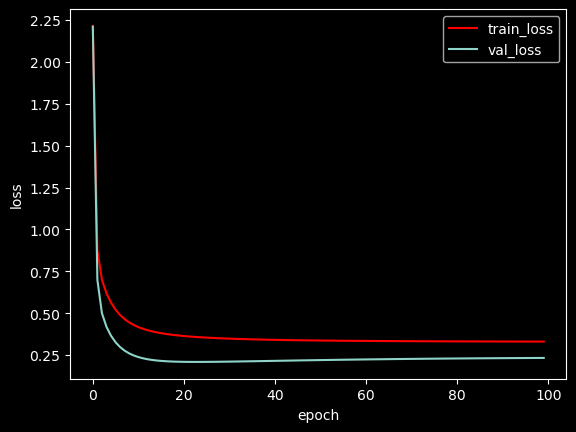

In [425]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(losses, c="red")
plt.plot(val_losses)
plt.legend(["train_loss", "val_loss"])
plt.show()

### Change the scale of the model's output to account for the standardization

**Assumptions**: the mean and std of the training set is std of the population.

Note that we have $${{y-\mu_y}\over\sigma_y} = {{\bold{x}-\mu_{\bold{x}}}\over\sigma_{\bold{x}}} \cdot \bold{w} + b$$
Then, we get $$y = \mu_y + \sigma_y{\bold{x}\cdot\bold{w}-\mu_{\bold{x}}\over\sigma_{\bold{x}}} + b\sigma_y$$

In [426]:
def model_scaled(X):
    return (mu_y + sigma_y*(((X-mu_X)/sigma_X) @ model.weight.data.numpy().T) + model.bias.data.numpy() * sigma_y)

In [427]:
# Real loss (in terms of dollars)
(1/outputs.shape[0]) * np.sqrt(np.abs(model_scaled(inputs[402:])**2 - outputs[402:]**2).sum()) * 1000

238.81655907913628